In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aakashacharya","key":"92db01bd2ff495b1169298c90c570a1c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:08<00:00, 175MB/s]
100% 1.04G/1.04G [00:08<00:00, 128MB/s]


In [6]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd Images

/content/Images


In [9]:
with open('../captions.txt') as file:  
    data = file.read()

In [10]:
li=data.split('\n')
li.pop(0)
li[0].split(',')[1] 

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [11]:
from collections import defaultdict 
mapping = defaultdict(list) 
i=0;
for line in li:
    i+=1;
    if(i==40456):
      break
    tokens=line.split(',') 
    img_id,img_desc=tokens[0],tokens[1]    
    img_path=img_id
    img_desc='<start>'+img_desc+'<end>'
    mapping[img_path].append(img_desc)
print(len(mapping))


8091


In [12]:
image_paths=list(mapping.keys())

train_captions = []
img_name_vector = []

for image_path in image_paths:
  caption_list = mapping[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))
        

In [13]:
top_k = 6000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

import pickle

# saving
with open('../tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import pickle


# loading
with open('../tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [15]:
import tensorflow as tf


top_k = 6000

tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

max_length = 34

In [16]:

import tensorflow as tf
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


In [18]:
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

In [19]:
feature_dict=dict()
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0],-1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    feature_dict[path_of_feature]=bf

In [20]:
feature_dict['1000268201_693b08cb0e.jpg']

<tf.Tensor: shape=(64, 2048), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.16978037],
       [0.        , 0.        , 1.0105118 , ..., 0.        , 0.        ,
        0.06112697],
       ...,
       [0.        , 0.        , 2.0380013 , ..., 1.2031502 , 0.        ,
        1.9926128 ],
       [0.        , 0.        , 0.90470666, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.2528076 , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [22]:
import random
img_to_cap_vector = defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.7)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

print(np.shape(cap_train))

(28315, 34)


In [23]:
def map_func(img, cap):
  return feature_dict[img.decode()].numpy(), cap

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
top_k = 6000
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

len(cap_train[0])

34

In [24]:
# class CNN_Encoder(tf.keras.Model):
#     # Since you have already extracted the features and dumped it
#     # This encoder passes those features through a Fully connected layer
#     def __init__(self, embedding_dim):
#         super(CNN_Encoder, self).__init__()
#         # shape after fc == (batch_size, 64, embedding_dim)
#         self.fc = tf.keras.layers.Dense(embedding_dim)

#     @tf.function(input_signature = [tf.TensorSpec(shape=[None, 64, 2048],)])
#     def call(self, x):
#         x = self.fc(x)
#         x = tf.nn.relu(x)
#         return x

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
top_k = 6000
vocab_size = top_k + 1

def encoder(img_inputs):
  x=tf.keras.layers.Dense(embedding_dim)(img_inputs)
  output = tf.nn.relu(x)
  return output


In [29]:
# # hidden shape == (batch_size, hidden_size)
#     # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
#     hidden_with_time_axis = tf.expand_dims(hidden,1)

#     # attention_hidden_layer shape == (batch_size, 64, units)
#     attention_hidden_layer = (tf.nn.tanh(tf.keras.layers.Dense(units)(features) +
#                                          tf.keras.layers.Dense(units)(hidden)))

#     # score shape == (batch_size, 64, 1)
#     # This gives you an unnormalized score for each image feature.
#     score = tf.keras.layers.Dense(1)(attention_hidden_layer)

#     # attention_weights shape == (batch_size, 64, 1)
#     attention_weights = tf.nn.softmax(score, axis=1)

#     # context_vector shape after sum == (batch_size, hidden_size)
#     context_vector = attention_weights * features
#     context_vector = tf.reduce_sum(context_vector, axis=1)

#     return context_vector, attention_weights


# inputs to model
features = tf.keras.Input(shape=(64, 256,), name="features")
hidden = tf.keras.Input(shape=(units,), name="hidden")
x = tf.keras.Input(shape=(1,), name="x")

#prepare context vector
hidden_with_time_axis = tf.expand_dims(hidden,1)
a=tf.keras.layers.Dense(units)(features)
b=tf.keras.layers.Dense(units)(hidden_with_time_axis)
c = tf.keras.layers.Lambda(lambda x: tf.math.add(x[0], x[1]), name='add')([a, b])
attention_hidden_layer = tf.nn.tanh(c)

score = tf.keras.layers.Dense(1)(attention_hidden_layer)
attention_weights = tf.nn.softmax(score, axis=1)
context_vector = tf.keras.layers.Lambda(lambda x: tf.math.multiply(x[0], x[1]), name='mult')([attention_weights,features])
context_vector = tf.reduce_sum(context_vector, axis=1)

#decoder of the model
x1 = tf.keras.layers.Embedding(vocab_size, embedding_dim)(x)
x1 = tf.concat([tf.expand_dims(context_vector, 1), x1], axis=-1)
output, state = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')(x1)
x1 = tf.keras.layers.Dense(units)(output)
x1 = tf.reshape(x1, (-1, x1.shape[2]))
x1 = tf.keras.layers.Dense(vocab_size)(x1)

model = tf.keras.Model(
    inputs=[x,features,hidden],
    outputs=[x1,state,attention_weights],
)


In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [27]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

def train_step(img_tensor, target,batch):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  # tf.zeros((target.shape[0], self.units))
  hidden = tf.zeros((target.shape[0],units))

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = model([dec_input, features, hidden])
          
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = model.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [30]:
# print( (img_tensor))
# break
EPOCHS = 10
start_epoch = 0
import time
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        # print(target)
        # break
        batch_loss, t_loss = train_step(img_tensor, target,batch)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    model.save("/content/drive/MyDrive/models/model-epoch"+str(epoch))
        
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.7116
Epoch 1 Batch 100 Loss 1.5086
Epoch 1 Batch 200 Loss 1.4099
Epoch 1 Batch 300 Loss 1.2238
Epoch 1 Batch 400 Loss 1.1803


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch0/assets


Epoch 1 Loss 1.364060
Time taken for 1 epoch 335.92 sec

Epoch 2 Batch 0 Loss 1.3066
Epoch 2 Batch 100 Loss 1.2529
Epoch 2 Batch 200 Loss 1.2409
Epoch 2 Batch 300 Loss 1.1506
Epoch 2 Batch 400 Loss 1.1537


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch1/assets


Epoch 2 Loss 1.181798
Time taken for 1 epoch 337.79 sec

Epoch 3 Batch 0 Loss 1.1149
Epoch 3 Batch 100 Loss 1.0945
Epoch 3 Batch 200 Loss 1.0600
Epoch 3 Batch 300 Loss 1.1543
Epoch 3 Batch 400 Loss 1.2126


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch2/assets


Epoch 3 Loss 1.133421
Time taken for 1 epoch 336.06 sec

Epoch 4 Batch 0 Loss 1.0628
Epoch 4 Batch 100 Loss 1.2222
Epoch 4 Batch 200 Loss 1.0873
Epoch 4 Batch 300 Loss 1.1320
Epoch 4 Batch 400 Loss 1.0541


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch3/assets


Epoch 4 Loss 1.104663
Time taken for 1 epoch 334.87 sec

Epoch 5 Batch 0 Loss 1.1057
Epoch 5 Batch 100 Loss 1.1509
Epoch 5 Batch 200 Loss 1.1240
Epoch 5 Batch 300 Loss 1.1330
Epoch 5 Batch 400 Loss 1.1044


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch4/assets


Epoch 5 Loss 1.083305
Time taken for 1 epoch 335.62 sec

Epoch 6 Batch 0 Loss 1.0702
Epoch 6 Batch 100 Loss 1.1065
Epoch 6 Batch 200 Loss 1.1012
Epoch 6 Batch 300 Loss 1.1499
Epoch 6 Batch 400 Loss 1.0463


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch5/assets


Epoch 6 Loss 1.065175
Time taken for 1 epoch 337.38 sec

Epoch 7 Batch 0 Loss 1.0040
Epoch 7 Batch 100 Loss 1.0539
Epoch 7 Batch 200 Loss 1.0440
Epoch 7 Batch 300 Loss 1.0470
Epoch 7 Batch 400 Loss 0.9362


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch6/assets


Epoch 7 Loss 1.050479
Time taken for 1 epoch 332.78 sec

Epoch 8 Batch 0 Loss 1.0287
Epoch 8 Batch 100 Loss 0.9421
Epoch 8 Batch 200 Loss 0.9436
Epoch 8 Batch 300 Loss 0.9888
Epoch 8 Batch 400 Loss 1.0765


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch7/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch7/assets


Epoch 8 Loss 1.038540
Time taken for 1 epoch 337.75 sec

Epoch 9 Batch 0 Loss 1.0673
Epoch 9 Batch 100 Loss 1.1022
Epoch 9 Batch 200 Loss 1.0250
Epoch 9 Batch 300 Loss 0.9972
Epoch 9 Batch 400 Loss 1.0611


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch8/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch8/assets


Epoch 9 Loss 1.028570
Time taken for 1 epoch 337.83 sec

Epoch 10 Batch 0 Loss 1.0253
Epoch 10 Batch 100 Loss 1.0285
Epoch 10 Batch 200 Loss 1.0312
Epoch 10 Batch 300 Loss 0.9385
Epoch 10 Batch 400 Loss 0.9886


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch9/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model-epoch9/assets


Epoch 10 Loss 1.019377
Time taken for 1 epoch 345.45 sec



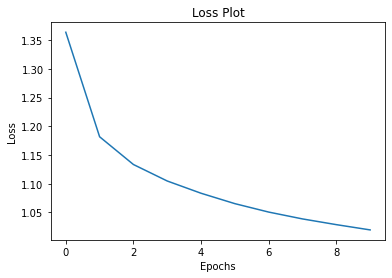

In [46]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
saved_model = tf.keras.models.load_model("/content/drive/MyDrive/models/model-epoch9")

In [47]:
def evaluate(image):

    hidden = tf.zeros((1,units))

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = model([dec_input,
                                                         features,
                                                         hidden])

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(predicted_id)

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

Real Caption: <start>a man is standing next to a bench drinking a soda while other people sit on a bench nearby <end>
Prediction Caption: person is pushing a boy and his coach for a pool with a pool<end> <unk> the ball outside drinking coffee <end>


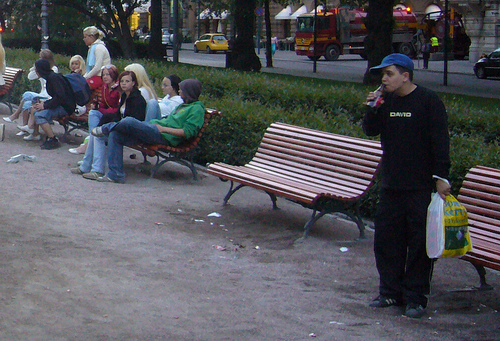

In [60]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result = evaluate(image)

result = ' '.join([tokenizer.index_word[i]
                        for i in result if i not in [0]])

from PIL import Image

print('Real Caption:', real_caption)
print('Prediction Caption:', result)
Image.open(img_name_val[rid])


In [61]:
reference=real_caption.split()
predict=result.split()

In [62]:
print(reference,predict)

['<start>a', 'man', 'is', 'standing', 'next', 'to', 'a', 'bench', 'drinking', 'a', 'soda', 'while', 'other', 'people', 'sit', 'on', 'a', 'bench', 'nearby', '<end>'] ['person', 'is', 'pushing', 'a', 'boy', 'and', 'his', 'coach', 'for', 'a', 'pool', 'with', 'a', 'pool<end>', '<unk>', 'the', 'ball', 'outside', 'drinking', 'coffee', '<end>']


In [63]:
import nltk
nltk.translate.bleu_score.sentence_bleu(reference,predict)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

1.012071042130996e-231